# VGG16 - TOBACCO - PSS One Page

Trying to reproduce the expirement from [here](https://github.com/uhh-lt/pss-lrev/blob/master/exp2_img-only_Tobacco800.ipynb)

### Data Processing

As always, we'll import the modules we need. No new imports yet.

In [103]:
#!pip3 install torch torchvision sklearn --user

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import pandas as pd
from PIL import Image

We'll also set the random seeds.

In [104]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Defining the Model

In [105]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features
        
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(0.5),
            nn.LeakyReLU(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
#        x = self.avgpool(x) 
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [106]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

In [107]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

Now, let's get the `features` for the VGG16 architecture, with batch normalization.

The original VGG paper did not use batch normalization, but it is now common to use it in VGG models.

In [108]:
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm = False)

We can print them out and ensure they are the same as the "A" configuration of the VGG configuration table.

In [109]:
#print(vgg16_layers)

We can then pass these `features` to our base VGG module to get our VGG11 model.

In [110]:
OUTPUT_DIM = 2

model = VGG(vgg16_layers, OUTPUT_DIM)

### Pre-trained Models

In [111]:
import torchvision.models as models

pretrained_model = models.vgg16(pretrained = True)

In [112]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [113]:
IN_FEATURES = pretrained_model.classifier[-1].in_features 

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

We can directly overwrite the previous linear layer with our new linear layer. 

Note that our `final_fc` will be initialized randomly. It is the only part of our model with its parameters not pre-trained.

In [114]:
pretrained_model.classifier[-1] = final_fc

...changing activation at head

We can then print out the `classifier` of our model to ensure the final linear layer now has an output dimension of 10.

In [115]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


...loading state dict from pre-trained into model

In [116]:
model.load_state_dict(pretrained_model.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['classifier.3.weight', 'classifier.3.bias'])

In [117]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 117,487,426 trainable parameters


In [118]:
classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(256, OUTPUT_DIM),
        )

In [119]:
model.classifier = classifier

In [120]:
#model.features

In [121]:
for name, parameter in model.features.named_parameters():
    if not name.startswith('28'):
        parameter.requires_grad = False

In [125]:
#for name, parameter in model.features.named_parameters():
#    print("{} {}".format(name, parameter.requires_grad))

In [123]:
model.features[-3:]

Sequential(
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Instead of training all of the parameters we have loaded from a pre-trained model, we could instead only learn some of them and leave some "frozen" at their pre-trained values. As our model will then have less trainable parameters it will usually train faster and we can usually fit it on smaller GPUs. 

We aren't going to freeze any parameters in this notebook, but if we wanted to freeze the `features` layer then we could do that with:

```python
for parameter in model.features.parameters():
    parameter.requires_grad = False
```

We could also freeze the `classifier` layer, however we always want to train the last layer as this is what we have initialized randomly and needs to be trained. Freezing all but the last layer in the `classifier` can be done with:

```python
for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = False
```

### Data Processing

In [128]:
pretrained_size = (224,224)
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
#                           transforms.RandomRotation(5),
#                           transforms.RandomHorizontalFlip(0.5),
#                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

The rest of this notebook will be similar to previous notebooks.

We'll load the data with our defined transforms...

In [129]:
PAGE_IMGS_PATH = '/mnt/nas/databases/Tobacco800/unziped/page_imgs/raw/'
TRAIN_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/train.csv'
TEST_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/test.csv'

In [130]:
df_train = pd.read_csv(TRAIN_LABEL_PATH, sep=';', skiprows=0, low_memory=False)
df_test = pd.read_csv(TEST_LABEL_PATH,sep=';', skiprows=0, low_memory=False) 

In [131]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
    
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        label2Idx = {'FirstPage' : 1, 'NextPage' : 0}
        if type(index) != int:
            i = index.item()
        else: i = index
        row = self.dataframe.iloc[i]
        img = Image.open(PAGE_IMGS_PATH+row["docid"]+'.tif').convert("RGB")
        return (
            test_transforms(img),
            label2Idx[row["class"]],
        )

In [132]:
VALID_RATIO = 0.9

n_train_examples = int(len(df_train) * VALID_RATIO)
n_valid_examples = len(df_train) - n_train_examples

In [133]:
train_data = Dataset(df_train)

valid_data = Dataset(df_test)

test_data = Dataset(df_test)

In [134]:
len(train_data)

1031

...then create the validation split...

In [135]:
#VALID_RATIO = 0.9

#n_train_examples = int(len(train_data) * VALID_RATIO)
#n_valid_examples = len(train_data) - n_train_examples

#train_indices = torch.arange(0,n_train_examples-1)
#valid_indices = torch.arange(n_train_examples,n_train_examples+n_valid_examples-1)

#train_data = data.Subset(train_data, train_indices )
#valid_data = data.Subset(train_data, valid_indices )

In [136]:
len(valid_data)

259

...and ensure the validation data uses the test transforms.

In [137]:
#valid_data = copy.deepcopy(valid_data)
#valid_data.dataset.transform = test_transforms

In [138]:
type(train_data)

__main__.Dataset

Again, we'll print out the number of examples in each split to ensure they are correct.

In [139]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
#print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1031
Number of validation examples: 259


We'll also plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

In [140]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
#        ax.set_title(labels[i])
        ax.axis('off')

As we can see, the larger images mean we can get away with larger amounts of rotation and cropping with the images still looking reasonable.

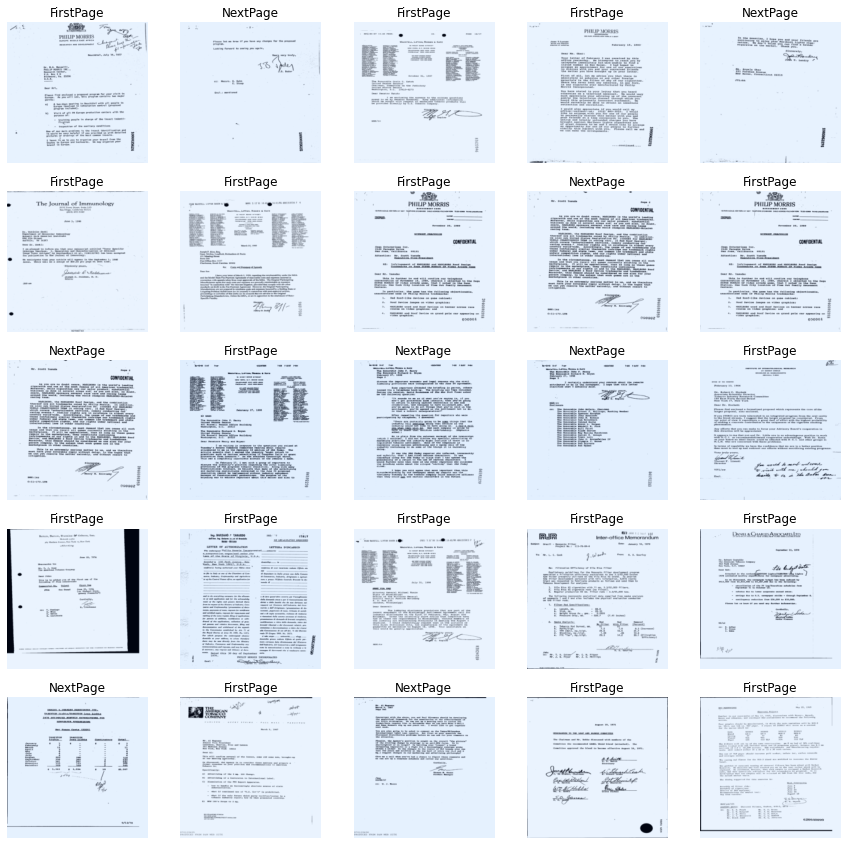

In [141]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = {1: 'FirstPage', 0: 'NextPage'}

plot_images(images, labels, classes)

As the model is ~5x the size of the AlexNet model from the previous notebook we use a smaller batch size so it can fit on reasonably sized GPUs. This should be increased if we have access to GPUs with more memory in order to speed up training.

In [142]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 batch_size = BATCH_SIZE, shuffle=False)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [143]:
# for i, (images, lables) in enumerate(valid_iterator):
#        for image in images:
#            print (image.shape)
#        break

### Training the Model

We'll use the learning rate finder as used in previous notebooks. Generally when using a pre-trained model the learning rate used will be considerably lower.

First, we'll set up the optimizer with the initial learning rate that is much lower than we expect to use. Then we define the `device` to place our model on our GPU, if we have one. Next we define the `criterion` (loss function) and place the model and criterion on our device.

In [145]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

cuda


We then define the learning rate finder class. See the previous notebook for details on how this works.

In [146]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

Next, we run the learning rate finder...

In [147]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


...and plot the loss achieved per batch for each learning rate value tested.

In [148]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see, the loss remains almost constant until around $1x10^{-4}$, it then decreases rapidly before diverging. 

A good learning rate from this is the middle of the steep decline which is around $5x10^{-4}$.

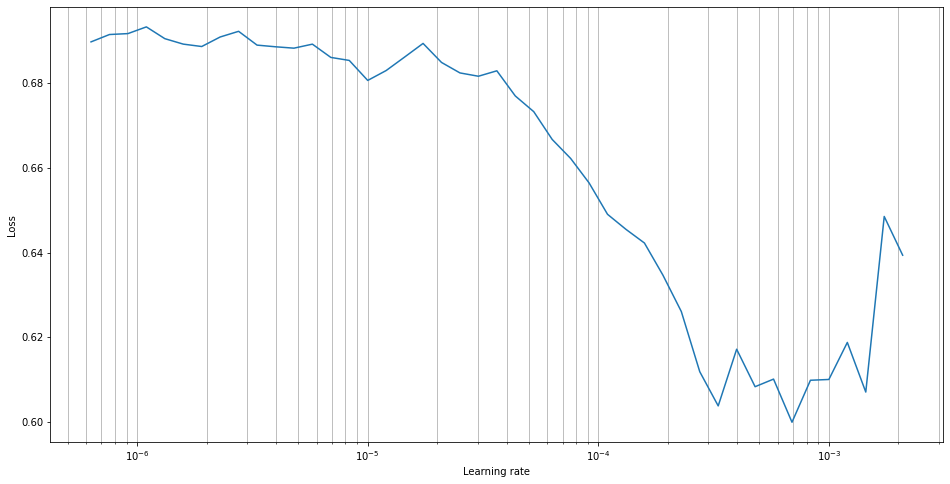

In [149]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

We can now create an optimizer with our found learning rate and using discriminative fine-tuning. 

The concept behind descriminative fine-tuning is that we use different learning rates for different layers in our models. The hypothesis is that early layers in a neural network learn to extract more general features, whilst later layers learn to extract more task specific features. If this is true, then the general features extracted by the early layers should be useful for any task, and we should change the pre-trained weights of them by a very small amount - if at all. 

**Note:** discriminative fine-tuning should only be used when performing transfer learning from a pre-trained model. It is typically not necessary to use it when training a model from randomly initialized weights. 

PyTorch allows us to set different learning rate values per parameter in our model. This is done by passing a list of dictionaries to the optimizer. Each dictionary should state the parameters (`'params'`) and also any other arguments that will override those given directly to the optimizer. 

Here, instead of using a different learning rate for every single layer, we have split the parameters into two "groups": `features`, which contains all of the convolutional layers; and `classifier`, which contains all of the linear layers. `classifier` will be using the `FOUND_LR` given directly to the optimizer and `features` will be using `FOUND_LR / 10`, as specified in the first dictionary. Thus, our convolutional layers have a learning rate 10x less than the linear layers.

In [157]:
0.0001/2

5e-05

In [158]:
FOUND_LR = 5e-5

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

Now all of the set-up is done, the rest of the notebook is pretty standard from here on out.

We create a function to calculate accuracy...

In [159]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...create a function that implements a training loop...

In [165]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        top_pred = y_pred.argmax(1, keepdim = True)
        
        kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_kappa += kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

...create a function that performs an evaluation loop...

In [169]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            top_pred = y_pred.argmax(1, keepdim = True)
        
            kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_kappa += kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

...and a helper function to tell us how long an epoch takes.

In [167]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly less epochs and are still able to achieve much higher accuracy than before.

We get ~94% validation accuracy in only five epochs.

In [170]:
EPOCHS = 3

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_kappa = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_kappa = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'new-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Kappa: {train_kappa*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Kappa: {valid_kappa*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 43s
	Train Loss: 0.335 | Train Acc: 88.64% | Train Kappa: 72.47%
	 Val. Loss: 0.318 |  Val. Acc: 87.50% |  Val. Kappa: 74.48%
Epoch: 02 | Epoch Time: 1m 38s
	Train Loss: 0.286 | Train Acc: 90.85% | Train Kappa: 77.96%
	 Val. Loss: 0.294 |  Val. Acc: 89.24% |  Val. Kappa: 77.90%
Epoch: 03 | Epoch Time: 1m 38s
	Train Loss: 0.242 | Train Acc: 91.86% | Train Kappa: 80.01%
	 Val. Loss: 0.276 |  Val. Acc: 89.93% |  Val. Kappa: 79.11%


Our test accuracy is a little lower at ~92%, but is still higher than the ~75% achieved by the AlexNet model in the previous tutorial notebook.

In [171]:
model.load_state_dict(torch.load('new-model.pt'))

test_loss, test_acc, test_kappa = evaluate(model, valid_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |  Test. Kappa: {test_kappa*100:.2f}%')

Test Loss: 0.276 | Test Acc: 89.93% |  Val. Kappa: 79.11%


### Examining the Model

We'll do the same examinations on the model as we have done on the previous notebooks.

First, we'll get the predictions for each of the examples in the test set...

In [173]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [174]:
images, labels, probs = get_predictions(model, test_iterator)

...then get the predicted labels for each image...

In [175]:
pred_labels = torch.argmax(probs, 1)

...and then use these predictions to create a confusion matrix.

In [176]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

Similar to the previous notebook, the most commonly confused classes are dogs and cats.

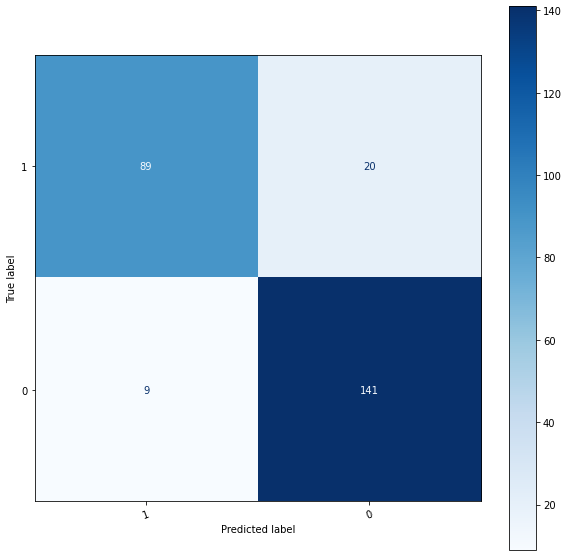

In [177]:
plot_confusion_matrix(labels, pred_labels, classes)

We'll then find out which predictions were incorrect and then sort these incorrect predictions by how confident our model was.

In [178]:
corrects = torch.eq(labels, pred_labels)

In [179]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot these most confident incorrect predictions.

In [180]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images)) 
    cols = int(np.sqrt(n_images)) -1

    fig = plt.figure(figsize = (30, 25))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        
        true_class = classes[true_label if type(true_label)==int else true_label.item()]
        incorrect_class = classes[incorrect_label if type(true_label)==int else incorrect_label.item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

Again, the frog that was incorrectly labelled as a cat is there with a lot of automobile/truck confusion.

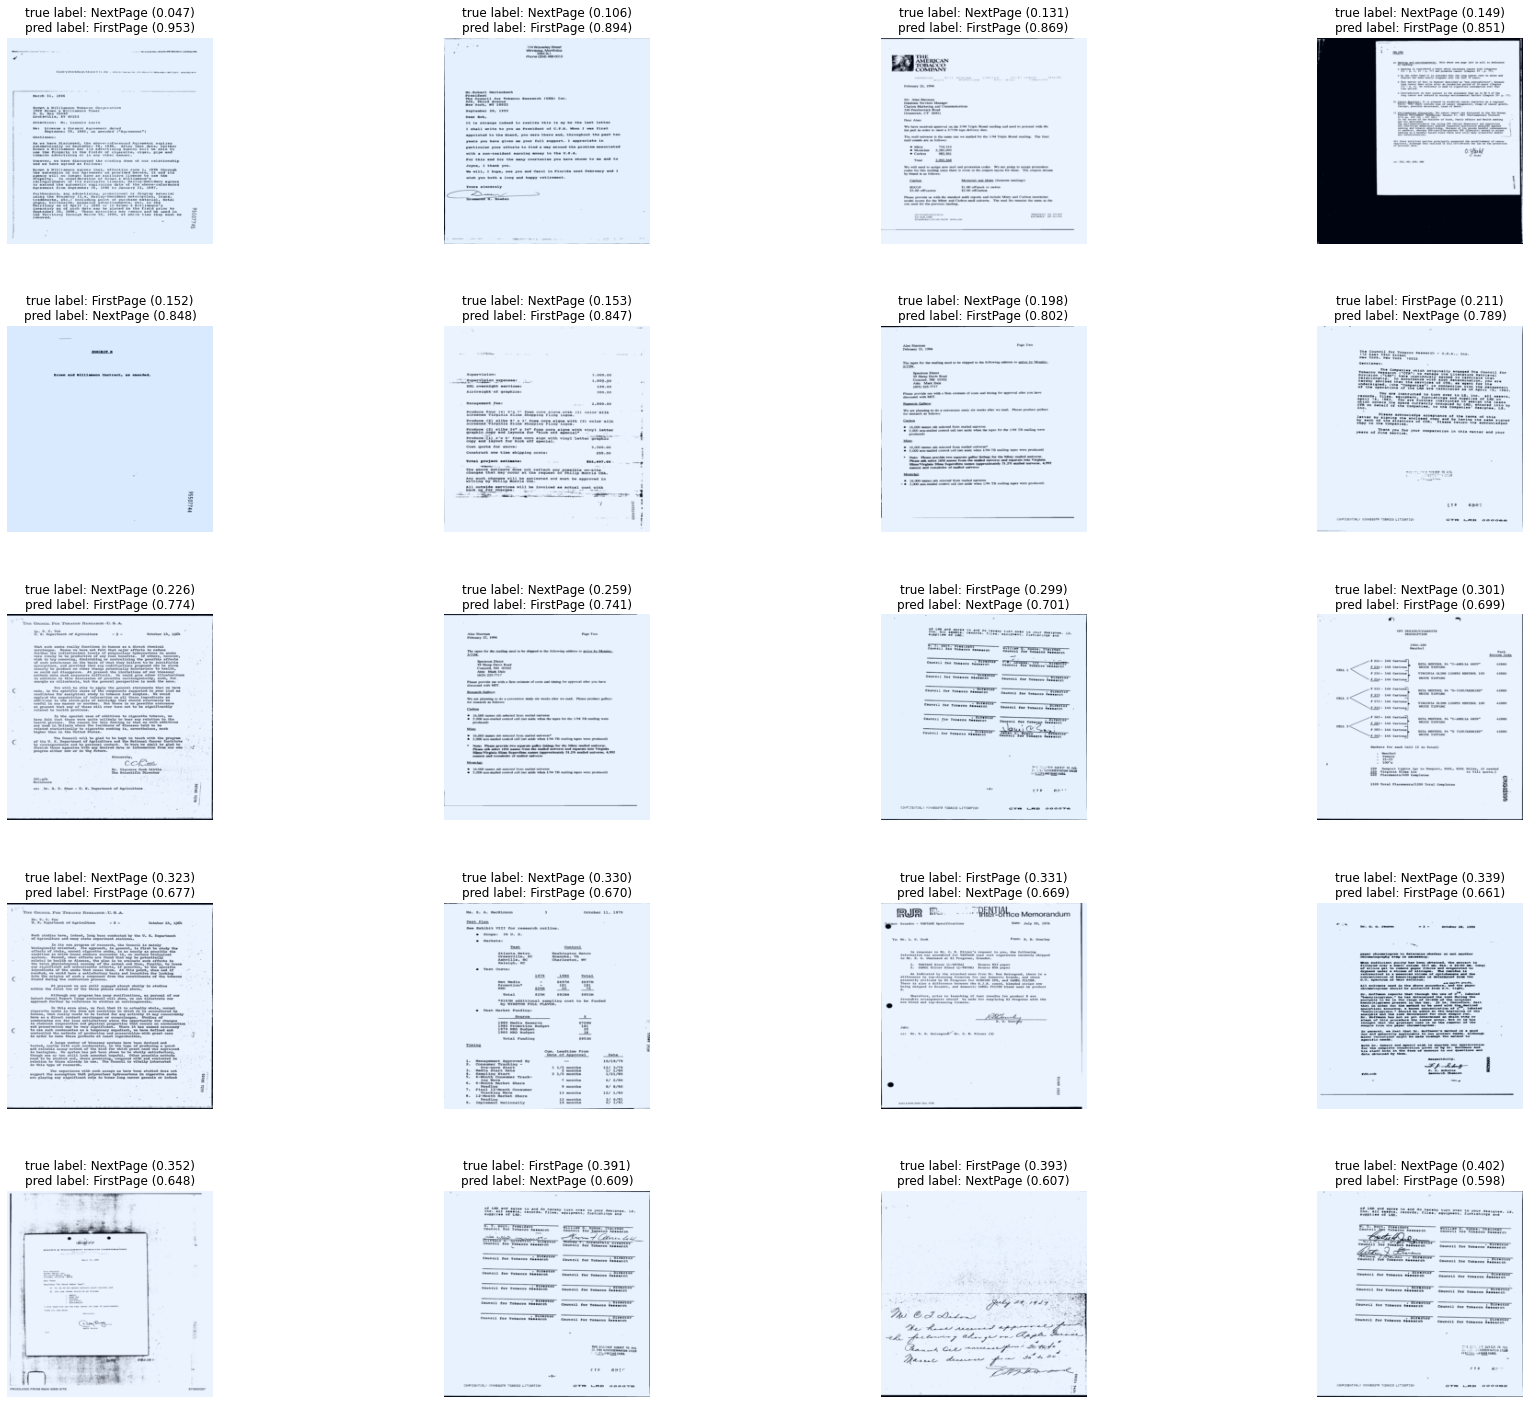

In [181]:
N_IMAGES = 36 if len(incorrect_examples) >= 36 else len(incorrect_examples)
classes = {1: 'FirstPage', 0: 'NextPage'}
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next up is plotting the representations of the model with PCA and then t-SNE.

We are only going to plot the output representations and not the intermediate ones here. This is because the output dimensions are ten dimensional but the intermediate representations have over 25,000 dimensions and storing these in memory takes a considerably amount of RAM.

In [77]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

First, we gets the output representations...

In [78]:
outputs, labels = get_representations(model, train_iterator)

Next, we define a function to perform PCA on the representations and plot the PCA output.

In [79]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [80]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

We can then plot the PCA representations.

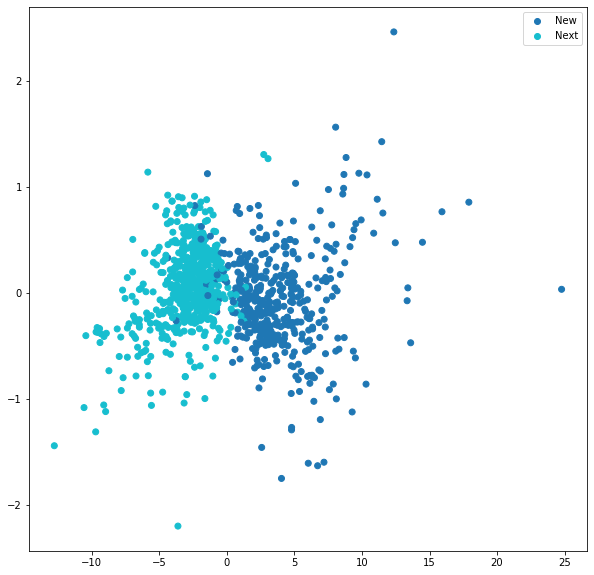

In [81]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, ['New','Next'])

Next up is calculating the t-SNE representations.

In [82]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

As mentioned in previous notebooks t-SNE takes a lot longer to compute compared to PCA, thus we only use a sample of the representations to calculate the t-SNE embeddings.

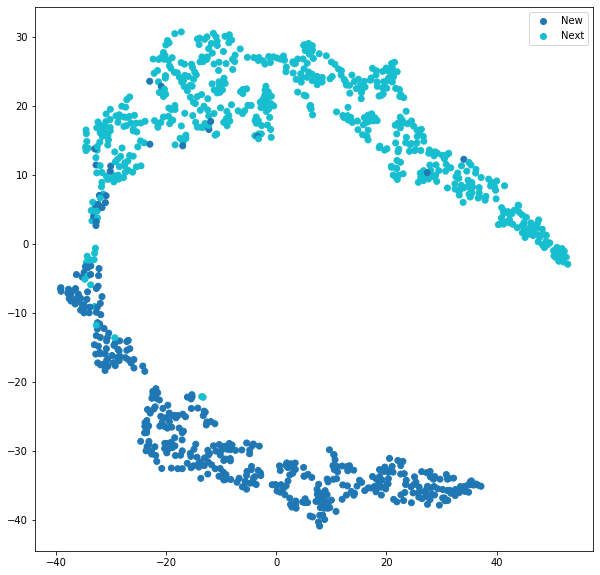

In [83]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, ['New','Next'], n_images = N_IMAGES)

We'll then get the filters learned by our model and plot some images with the filters applied to them.

In [84]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see that the filters learned by the model do different types of edge detection, color inversion and blurring.

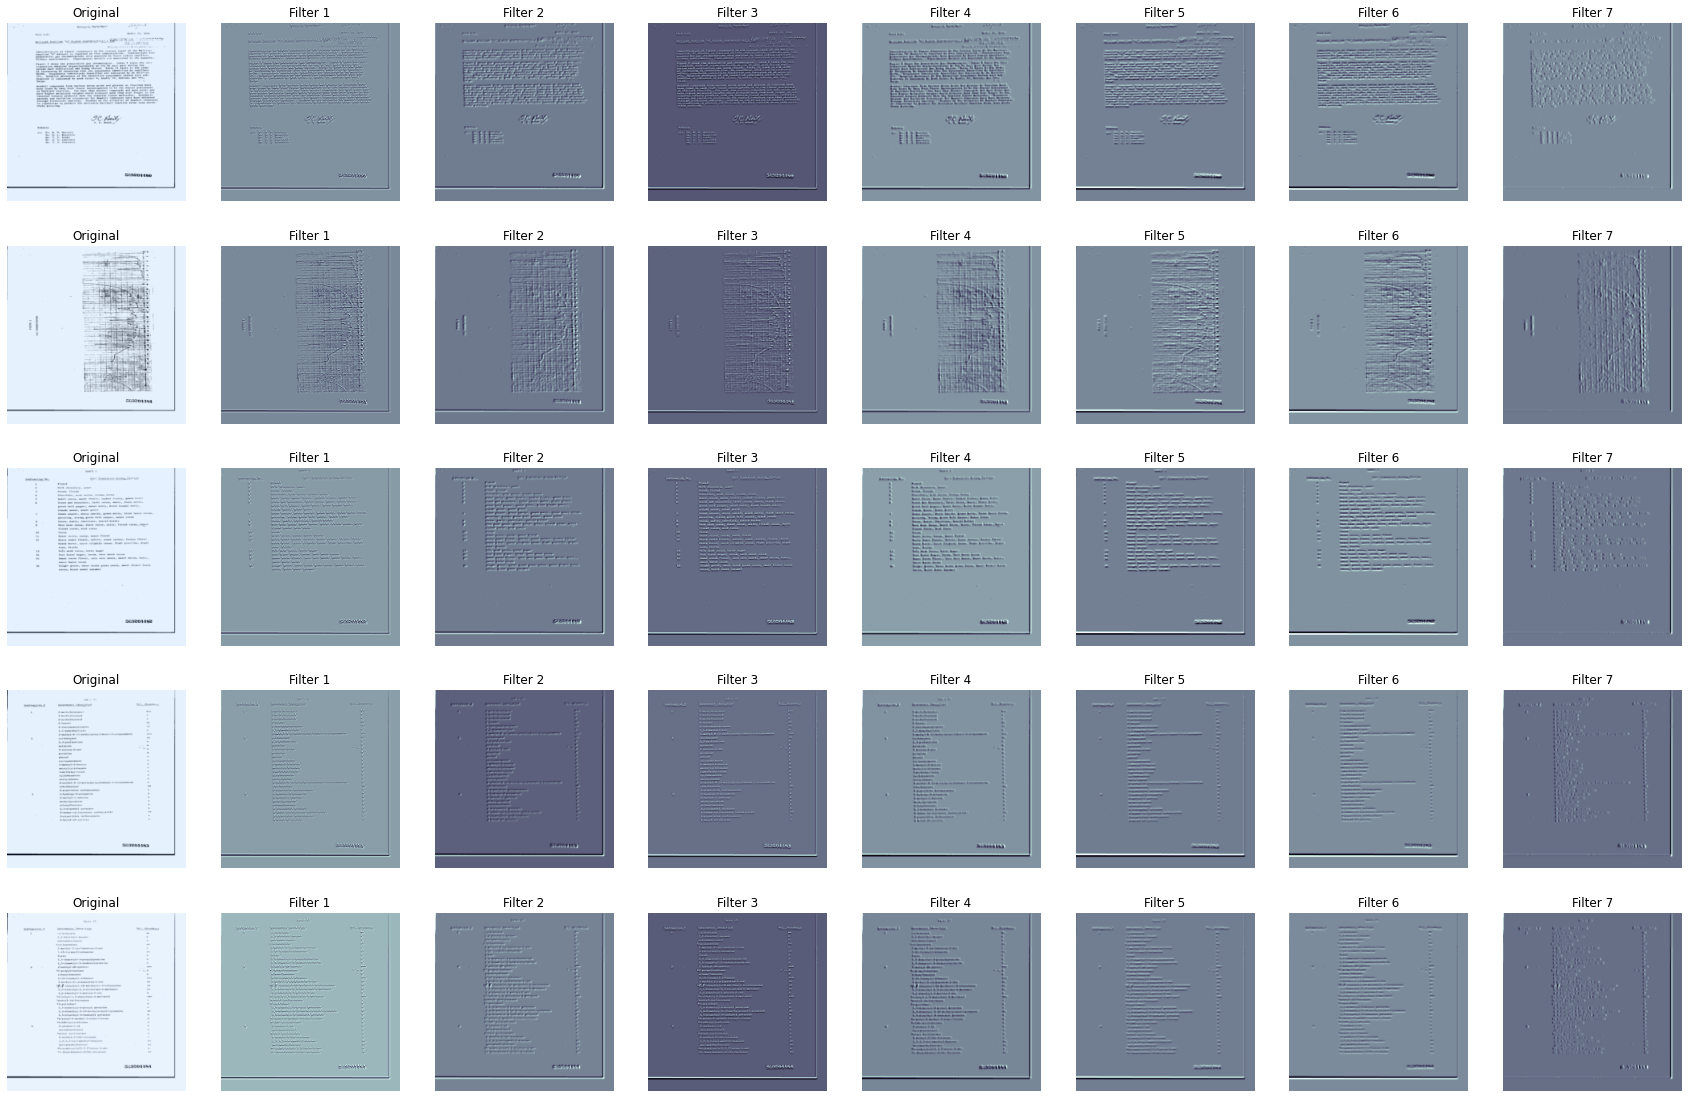

In [85]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

We can also plot out the actual filter weights learned by the model.

In [86]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

Even though these aren't as interpretable as the pre-trained AlexNet filters shown in the previous notebook, they are more interesting than the AlexNet filters learned from scratch. 

Interestingly there are multiple filters that are completely black, implying they all have filters weights that are basically zero.

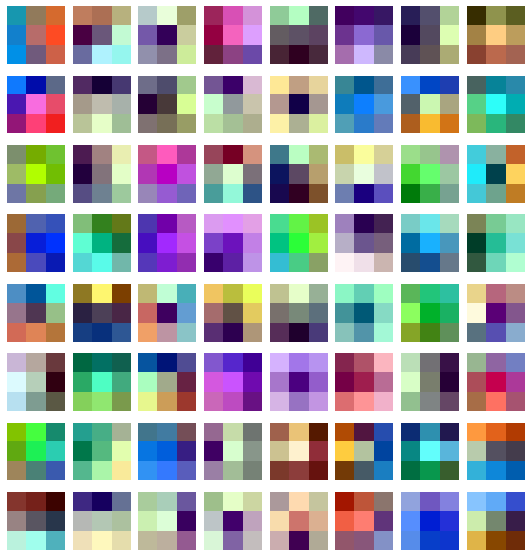

In [87]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (VGG)
- adaptive pooling
- batch normalization
- loading a pre-trained model
- loading pre-trained model parameters into a defined model
- how to freeze weights of our model
- how to use the learning rate finder
- how to use discriminative fine-tuning
- fine-tuning a pre-trained model to achieve >94% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- viewing the learned weights of our model

In the next notebook we'll implement yet another popular CNN architecture, ResNet, and learn about how to pre-trained models ourselves using self-supervised learning.